# RTS Smoothing
This notebook explores the Rauch-Tung-Striebel Smoother on a problem described in "Bayesian Filtering and Smoothing" by Sarkka.

We start by implementing a class that produces data -- see Example 4.3 in the book.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Start by implementing a simple state space model

In [2]:
class StateSpace:    
    def __init__(self, A, H, Q, R):
        self.A = A # state-transition matrix 
        self.H = H # observation matrix
        self.Q = Q # state noise covariance
        self.R = R # observation noise covariance
        self.x = self.reset()
    def reset(self):
        return np.zeros(self.A.shape[0])
    def __call__(self):
        """
        single data generation step
        """
        self.x = self.A.dot(self.x) + np.random.multivariate_normal(np.zeros(self.x.size), self.Q)
        obs = self.H.dot(self.x) + np.random.multivariate_normal(np.zeros(self.H.shape[0]), self.R)
        return obs, self.x.copy()

In [3]:
class CarData:
    def __init__(self, dt = 1e-1, q1=1., q2=1., sigma1=0.5, sigma2=0.5):
        iden = np.eye(2)
        z = np.zeros((2,2))
        A = np.block([[iden,dt * iden],
                      [z, iden]
                     ])
        H = np.block([iden, z])
        q = np.array([q1,q2])
        b1 = np.diag(dt**3/3 * q)
        b2 = np.diag(dt**2/2 * q)
        b3 = np.diag(dt * q)
        Q = np.block([[b1,b2],[b2,b3]])
        R = np.diag([sigma1**2, sigma2**2])
        self.state_space = StateSpace(A, H, Q, R)
    def __call__(self):
        return self.state_space()

In [4]:
car = CarData()
dat = [car() for _ in range(200)]
y, x = zip(*dat)
y = np.stack(y)

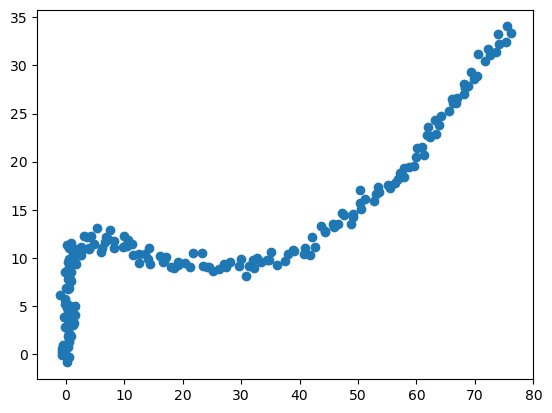

In [5]:
fig, ax = plt.subplots()
ax.scatter(y[:,0], y[:,1])